# THIS IS A DEMO FOR OUR APPROACH

PREPARING REQUIREMENTS

In [1]:
# PREPARING REQUIREMENTS
import torch
import kagglehub
from PIL import Image
import requests
import os
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
from itertools import combinations

# CAPTIONS
from transformers import AutoProcessor, AutoModelForImageTextToText
# CAPTIONS TO VECTORS
from sentence_transformers import SentenceTransformer
# LABELS
from transformers import pipeline

SETTING UP MODELS,
BY DEFAULT A FOLDER CONTAINING IMAGES IS SET FOR DEMONSTRATION BUT YOU CAN USE YOUR OWN DATASET OR FOLDER.

In [2]:
# DOWNLOAD DATASET AND LOAD MODELS
path = kagglehub.dataset_download("pratik2901/animal-dataset")
# PATH TO THE TEST FOLDER
path="/root/.cache/kagglehub/datasets/pratik2901/animal-dataset/versions/1/animal_dataset_intermediate/test"
# SETTING UP THE MODELS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# CAPTIONS
processor_cap = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_cap = AutoModelForImageTextToText.from_pretrained("Salesforce/blip-image-captioning-base")
model_cap.to(device, dtype=torch.float16)
# CAPTIONS TO VECTORS
model_enc = SentenceTransformer('distilbert-base-nli-mean-tokens')
model_enc.to(device, dtype=torch.float16)
# LABELS
unmasker = pipeline('fill-mask', model='bert-base-uncased')
warnings.filterwarnings("ignore", message="You seem to be using the pipelines sequentially on GPU.*")


100%|██████████| 225M/225M [00:10<00:00, 21.4MB/s]

Extracting files...



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.80k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


DEFINING FUNCTIONS

In [18]:
# DEFINING FUNCTIONS
def caption_images_in_folder(folder_path):
    # Dictionary to store image paths and captions
    captions_dict = {}

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith((".jpg", ".jpeg", ".png")):  # Add more formats if needed
            image_path = os.path.join(folder_path, filename)

            # Load and preprocess the image
            image = Image.open(image_path)
            pixel_values = processor_cap(images=image, return_tensors="pt").pixel_values.to(device)

            # Generate the caption
            generated_ids = model_cap.generate(pixel_values)
            caption = processor_cap.decode(generated_ids[0], skip_special_tokens=True)

            # Add the image path and caption to the dictionary
            captions_dict[image_path] = caption

    return captions_dict



def caption_to_vectors(captions):
    # Dictionary to store image paths and captions
    vectors_dict = {}

    for i in captions:
      encoding = model_enc.encode(captions[i])
      #print(encoding)
      vectors_dict[i]=encoding

    return vectors_dict



def locations_captions_for_labels(label_index):
  locations=[]
  captions_fl=[]
  for vector, label in zip(encoding_vectors, labels):
    if(label==label_index):
      for loc in vectors:
        if((vectors[loc]==vector).all()):
          locations.append(loc)

  return locations


# Function to display images in a grid
def display_images_grid(image_paths, grid_size=(2, 2)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(5, 5))
    for ax, path in zip(axes.flat, image_paths):
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()


def get_label():
  similarities=[]
  sim=[]
  for i in range(10):
    loc1=loc[:i+1]
    loc1=loc1[0]
    encoding1=model_enc.encode(captions[loc1])

    for prediction in predictions:
      encoding2 = model_enc.encode(prediction['token_str'])
      similarity = np.dot(encoding1, encoding2) / (np.linalg.norm(encoding1) * np.linalg.norm(encoding2))
      pair=[similarity,prediction['token_str']]
      similarities.append(pair)

  words = captions[loc1].split()  # Split sentence into words

  # Generate combinations in ascending order
  all_phrases = []
  for r in range(1, len(words)):  # r is the phrase length
      all_phrases += [' '.join(comb) for comb in combinations(words, r)]

  for phrase in all_phrases:
    encoding2 = model_enc.encode(phrase)
    similarity = np.dot(encoding1, encoding2) / (np.linalg.norm(encoding1) * np.linalg.norm(encoding2))
    pair=[similarity,phrase]
    sim.append(pair)

  if(max(similarities)[0]>0.6):
    label=max(similarities)[1]
  elif(max(sim)[0]>0.9):
    label=max(sim)[1]
  else:
    label=max(max(similarities)[1],max(sim)[1])
  return label



def get_details(cluster_number):
  loc=locations_captions_for_labels(int(cluster_number))
  display_images_grid(loc, grid_size=(2, 2))
  prompt=""
  cluster=[]
  for loca in loc[:5]:
    cluster.append(captions[loca])

  # Define the label with a placeholder
  label = "[MASK]"
  # Create the prompt
  prompt = f'cluster = {cluster}\nlabel = ["{label}"]'
  #print(prompt)
  predictions=unmasker(prompt)
  return loc, predictions



def overview():
  print("Maximum Cluster index: " + str(max(labels)))
  print("Minimum Cluster index: " + str(min(labels)))
  print("Total Images: " + str(len(labels)))

# ACTUAL IMPLEMENTATION OF OUR PIPELINE.

YOU CAN CHANGE THE FOLDER PATH ACCORDING TO YOUR REQUIREMENTS.

In [4]:
# WORKING / IMPLEMENTATION
# PREPARING CAPTIONS
folder_path = path
captions = caption_images_in_folder(folder_path)
  #print(captions)
# PREPARING VECTORS
vectors=caption_to_vectors(captions)
encoding_vectors=[]
encoding_vectors = [vectors[i] for i in vectors]
# APPLY DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=2, metric='euclidean')
labels = dbscan.fit_predict(encoding_vectors)


OVERVIEW OF THE RESULTS.

In [5]:
overview()

Maximum Cluster index: 93
Minimum Cluster index: -1
Total Images: 910


GET RESULTS:
GET THE CLUSTER DETAILS, BY CHANGING THE CLUSTER NUMBER.

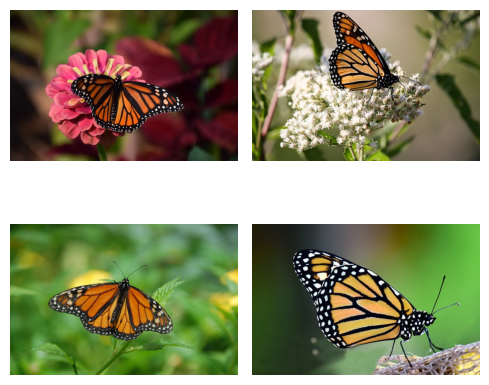

Label: butterfly


In [19]:
cluster_number=17
loc, predictions = get_details(cluster_number)
lab=get_label()
print("Label: "+lab)